# Out of Fashion

## Introduction
I've decided to take what I've been learning about language generation and apply it to images, just to spice things up. What could possibly go wrong?

## Import Dependancies

In [7]:
import torch                      # Tensors with backpropagation.
import pandas as pd               # Data manipulation.
import matplotlib.pyplot as plt   # Graphs and image display.

In [8]:
# Make dataframe of the pixels in fashion images.
training = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")

In [9]:
# Select images with T-shirts/tops.
shirts_df = training[training["label"] == 0].drop(columns=["label"])
shirts_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
10,0,0,0,0,1,0,0,0,0,41,...,164,177,163,0,0,1,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24,0,0,0,0,0,0,0,0,40,122,...,125,93,87,49,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,2,...,154,118,66,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59934,0,0,0,0,0,0,0,0,41,142,...,70,24,0,0,0,0,0,0,0,0
59957,0,0,0,0,0,0,0,0,1,0,...,186,196,200,0,0,3,0,0,0,0
59967,0,0,0,0,0,0,0,2,0,0,...,88,54,0,0,1,0,0,0,0,0
59980,0,0,0,2,0,0,0,0,0,3,...,37,25,9,0,0,0,0,0,0,0


## Examine Data

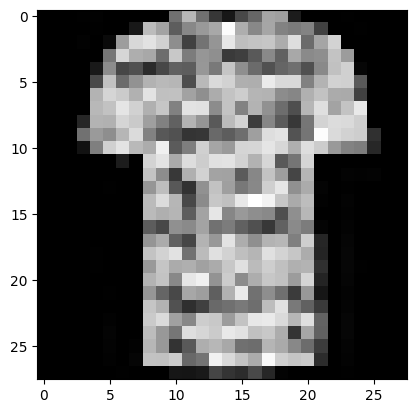

In [10]:
# Convert to a tensor and reshape to fit original image dimensions.
shirts = torch.tensor(shirts_df.values).view(-1, 28, 28)
# Display the first shirt from our data.
plt.imshow(shirts[0], cmap="gray")

In [11]:
shirts.size()

torch.Size([6000, 28, 28])

## Preparing the Data

To prevent overfitting, we'll need to split our data into training and dev splits. We'll train with 80% of the data and validate with the other 20%.

In [12]:
# Shuffle the shirts before splitting.
indices = torch.randperm(shirts.size(0))
shuffled_shirts = shirts[indices]

# Split at 80%.
split_idx = int(0.8 * len(shuffled_shirts))
# First 80% will be used as training, last 20% will be used as dev.
training = shuffled_shirts[:split_idx]
dev = shuffled_shirts[split_idx:]

For this first attempt, we'll start simple. The context for each pixel will be the `block_size` previous pixels. This won't take into account the dimensionality of the image and will most likely work very poorly, but for now we will use it as a baseline.

In [24]:
def get_X_y(images, block_size=10):
    """
    Breaks data into two tensors, X and y.
    X: One row per pixel, each row containing previous `block_size` pixels. Will be used as input to the model.
    y: Contains our labels, the target pixels' values. The model should learn to predict these values.
    """
    # Make sure images are flattened.
    images = images.view(images.size(0), -1)
    
    # X contains the contexts.
    X = []    # size (6000, block_size).
    # y contains the labels, a.k.a. the target pixels' values.
    y = []    # size 6000

    # Add padding by starting with all black pixels. (0 is black.)
    context = [0] * block_size
    # Use a sliding window to get all contexts.
    for image in images:
        for pixel in image.tolist():
            X.append(context)      
            y.append(pixel)
            # Slide window over by removing oldest pixel and adding newest pixel to the end.
            context = context[1:] + [pixel]
    return X, y

In [25]:
# Get examples and labels for the training and dev sets.
train_X, train_y = get_X_y(training)
dev_X, dev_y = get_X_y(dev)

_____________

## Preparing the Data
For this first attempt, I'll be using previous adjacent pixels as context. Specifically, we'll be using the three pixels above the target and the one pixel to the left of it. (The other adjacent pixels wouldn't have yet been seen by the model.)

We'll need to pad the top and left of the images so that each target pixel can be surrounded by pixels.

To quote the data description, "To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix."

Brainstorming:
More context (more of the pixels surrounding target pixel) can help for better results. So we'll start small, just the pixels directly adjacent. Later, we'll work our way up to selecting more surrounding pixels.

Getting context:
Imagine the context is like a square surrounding the target pixel, but not including any of the pixels within the square that would come after this one. 

(So context is like an isosceles triangle? <- no, that doesn't account for the pixel to the upper right of the target.)

Surrounding square will have dimensions (n, n). n should always be an odd number, since target should be right in the center.

In [15]:
# Context square will have dimensions (n, n).
n = 5
# Find num pixels in square apart from target.
surrounding_pixels = n * n - 1
# We're only looking at pixels on the top half of the surrounding square.
context_size = surrounding_pixels / 2
context_size

12.0

In [ ]:
# context = torch.zeros()
# X contains the contexts.
X = []    # size (6000, context_size).
# y contains the labels, a.k.a. the target pixels' values.
y = []    # size 6000

Psudocode:

    For shirt in shirts:
        context = [0] * context_size
        for pixel in padded_shirt:
            # Fill context here.
            context += 
        X.append(context)

<!-- Say left corner of context square is in position (3, 2). -->
Say target is in position (4, 3). Top left corner of context will be in position n
... 

(n - 1) / 2

<!-- Say pixel is in position (4, 3). Where are the pixels in the context? Assume context square is n x n. Target is always in center of square. So target should be in position x = (4 + n)/2, and y = (3 + n)/2 -->

if square starts at row 0 col 0, 
<!-- target should be in position x = (4 + n)/2, and y = (3 + n)/2. -->
___ of that square.